In [48]:
import os
import pandas as pd
from bs4 import BeautifulSoup
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import StringIO

pd.options.display.max_columns = 50

# Get html files to parse
- note this assumes they're in a directory `data/transits_2025.02.17_100_days`, adjust as needed
- adjust the `output_dir` as needed below as well

In [3]:
file_dir = 'data/transits_2025.02.17_100_days'
files = [f for f in os.listdir(file_dir) if 'Observatory' in f]
print(f'found {len(files)} files')

found 7 files


In [13]:
output_dir = 'data/'

# Parse transit data from html

In [4]:
def parse_timing_cell(cell):
    """Parse a single timing cell containing date, time, Alt, Azi, and HA"""
    text = cell.get_text(separator='|', strip=True)
    parts = text.split('|')
    
    # Extract date and time
    date_str = parts[0]
    time_str = parts[1]
    datetime_str = f"{date_str} {time_str}"
    timestamp = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M')
    
    # Extract Alt, Azi, and HA
    alt = float(re.search(r'Alt: (\d+)°', text).group(1))
    azi_match = re.search(r'Azi: (\d+)° \((.*?)\)', text)
    azi_deg = float(azi_match.group(1))
    azi_dir = azi_match.group(2)
    ha = float(re.search(r'HA: ([\d.]+)h', text).group(1))
    
    return {
        'timestamp': timestamp,
        'alt': alt,
        'azi_deg': azi_deg,
        'azi_dir': azi_dir,
        'ha': ha
    }

def parse_observation_timings(notes_table):
    """Parse the nested table containing observation timing data"""
    timing_rows = notes_table.find_all('tr')
    
    # Initialize timing data
    timing_data = {
        'optimal_target_note': '',
        'drifting_ephemeris_note': '',
        'meridian_crossing': None,
        'max_counts_r': None,
        'max_counts_v': None,
        'moon_illumination': None,
        'moon_distance': None
    }
    
    # Find the row with the timing cells (usually first or second row)
    timing_row = None
    for row in timing_rows:
        if len(row.find_all('td')) == 5:  # This is our timing row
            timing_row = row
            break
    
    if not timing_row:
        return timing_data
    
    # Parse each timing column
    timing_cells = timing_row.find_all('td')
    timing_types = ['before_ingress', 'transit_start', 'mid_transit', 'transit_end', 'after_egress']
    
    for timing_type, cell in zip(timing_types, timing_cells):
        cell_data = parse_timing_cell(cell)
        for key, value in cell_data.items():
            timing_data[f'{timing_type}_{key}'] = value
    
    # Look for special notes in first row
    first_row = timing_rows[0]
    if len(timing_rows) > 2 and len(first_row.find_all('td')) == 1:  # Special note present
        note_text = first_row.get_text(strip=True)
        if 'OPTIMAL TARGET NOTE' in note_text:
            timing_data['optimal_target_note'] = note_text
        elif 'DRIFTING EPHEMERIS NOTE' in note_text:
            timing_data['drifting_ephemeris_note'] = note_text
    
    # Parse the last row for additional metadata
    last_row = timing_rows[-1]
    last_row_text = last_row.get_text()
    
    # Extract meridian crossing
    meridian_match = re.search(r'Meridian crossing at: ([\d/: ]+)', last_row_text)
    if meridian_match:
        timing_data['meridian_crossing'] = datetime.strptime(
            meridian_match.group(1), '%Y/%m/%d %H:%M'
        )
    
    # Extract max counts
    max_counts_match = re.search(r'Max counts.*R:(\d+)%.*V:(\d+)%', last_row_text)
    if max_counts_match:
        timing_data['max_counts_r'] = int(max_counts_match.group(1))
        timing_data['max_counts_v'] = int(max_counts_match.group(2))
    
    # Extract moon data
    moon_match = re.search(
        r'Moon illumination: (\d+\.\d+)%, Moon distance: (\d+\.\d+)°',
        last_row_text
    )
    if moon_match:
        timing_data['moon_illumination'] = float(moon_match.group(1))
        timing_data['moon_distance'] = float(moon_match.group(2))
    
    return timing_data

In [5]:
def parse_first_column(col):
    """Parse the first column containing planet name, priority, and observations"""
    # Get planet name from the first font tag
    planet_name = col.find('font').text.strip()
    
    # Get priority from the second font tag
    priority = col.find_all('font')[1].text.strip()
    
    # Split the text by <br /> to get the other fields
    # Convert br tags to a delimiter we can split on
    for br in col.find_all('br'):
        br.replace_with('|')
    
    # Split the text and clean up
    parts = [part.strip() for part in col.text.split('|')]
    
    # Extract min aperture - it's in the format "Min. aperture: X.XX""
    min_aperture = float(parts[1].replace('Min. aperture: ', '').replace('"', ''))
    
    # Extract observations - format "Total Observations (Recent): X (Y)"
    obs_text = parts[2].replace('Total Observations (Recent): ', '')
    total_obs, recent_obs = obs_text.split(' (')
    total_obs = int(total_obs)
    recent_obs = int(recent_obs.rstrip(')'))
    
    # Extract O-C - format "O-C: X.XX ± Y.YY minutes"
    oc_text = parts[3].replace('O-C: ', '').replace(' minutes', '')
    if len(oc_text.strip()) > 1:
        o_c, o_c_uncertainty = map(float, oc_text.split(' ± '))
    else:
        o_c, o_c_uncertainty = (None, None)
    
    return {
        'planet_name': planet_name,
        'priority': priority,
        'min_aperture': min_aperture,
        'total_observations': total_obs,
        'recent_observations': recent_obs,
        'o_c': o_c,
        'o_c_uncertainty': o_c_uncertainty
    }

In [6]:
def parse_exoplanet_table(html_file):
    # Read and parse HTML
    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # Find the main table
    main_table = soup.select_one("div.page-content > div[align=center] > table")
    # print('main_table', main_table)
    
    # tbody = main_table.find('tbody')
    rows = main_table.find_all('tr', recursive=False)[2:]  # Skip first two header rows
    
    data = []
    for row in rows:
        # Get only direct child td elements
        # This gives us our three main columns
        cols = row.find_all('td', recursive=False)
        if len(cols) != 3:  # Skip malformed rows
            continue
            
        # First column parsing (planet info)
        try:
            planet_metadata = parse_first_column(cols[0])
        except Exception as e:
            print(cols[0])
            raise Exception(f'failed with excpeton: {e}')

        # Second column parsing (coordinates and properties)
        ra = re.search(r'RA: ([\d.:]+)', cols[1].text).group(1)
        dec = re.search(r'DEC: ([+-][\d.:]+)', cols[1].text).group(1)
        mag_r = float(re.search(r'Mag(?:R|_R): ([\d.]+)', cols[1].text).group(1))
        depth_r = float(re.search(r'Depth(?:R|_R): ([\d.]+)', cols[1].text).group(1))
        duration = float(re.search(r'Duration: ([\d.]+)', cols[1].text).group(1))
        
        # Third column parsing (notes and additional data)
        notes_col = cols[2]

        # Third column parsing (observation timings and notes)
        notes_table = cols[2].find('table')
        timing_data = parse_observation_timings(notes_table)
        
        # Extract special notes if present
        optimal_note = ''
        if note_elem := notes_col.find(string=re.compile('OPTIMAL TARGET NOTE')):
            optimal_note = note_elem.strip()
            
        drifting_note = ''
        if note_elem := notes_col.find(string=re.compile('DRIFTING EPHEMERIS NOTE')):
            drifting_note = note_elem.strip()
            
        # Extract meridian crossing
        meridian_match = re.search(r'Meridian crossing at: ([\d/: ]+)', notes_col.text)
        meridian_crossing = None
        if meridian_match:
            meridian_crossing = datetime.strptime(meridian_match.group(1), '%Y/%m/%d %H:%M')
            
        # Extract max counts
        max_counts_match = re.search(r'Max counts.*R:(\d+)%.*V:(\d+)%', notes_col.text)
        max_counts_r = max_counts_v = None
        if max_counts_match:
            max_counts_r, max_counts_v = map(int, max_counts_match.groups())
            
        # Extract moon data
        moon_match = re.search(r'Moon illumination: (\d+\.\d+)%, Moon distance: (\d+\.\d+)°', notes_col.text)
        moon_illumination = moon_distance = None
        if moon_match:
            moon_illumination, moon_distance = map(float, moon_match.groups())
        
        # Compile row data
        row_data = planet_metadata
        row_data.update({
            'ra': ra,
            'dec': dec,
            'mag_r': mag_r,
            'depth_r': depth_r,
            'duration': duration,
            'optimal_target_note': optimal_note,
            'drifting_ephemeris_note': drifting_note,
            'meridian_crossing': meridian_crossing,
            'max_counts_r': max_counts_r,
            'max_counts_v': max_counts_v,
            'moon_illumination': moon_illumination,
            'moon_distance': moon_distance
        })

        # Update row_data with timing information
        row_data.update(timing_data)
        data.append(row_data)
    
    return pd.DataFrame(data)

In [7]:
start_date = '2025-03-15'
end_date = '2025-05-15'

# expects pandas.Series as input
datetime_mask_func = lambda x: (x >= pd.to_datetime(start_date + ' 00:00:00')) & (x <= pd.to_datetime(end_date + ' 23:59:59'))
duration_mask_func = lambda x: (x <= 6.0)

df_transits = pd.DataFrame()
# file = files[0]
for file in files:
    observatory_name = file.replace('.html', '').replace(' ', '_').lower()
    file_path = os.path.join(file_dir, file)
    print(f'parsing: {file_path} for observatory: {observatory_name}')
    _df = parse_exoplanet_table(file_path)
    _df['observatory'] = observatory_name
    df_filtered = _df[datetime_mask_func(_df['after_egress_timestamp']) & duration_mask_func(_df['duration'])]
    df_transits = pd.concat([df_transits, df_filtered])

parsing: data/transits_2025.02.17_100_days/Siding Spring Observatory.html for observatory: siding_spring_observatory
parsing: data/transits_2025.02.17_100_days/Cerro Tololo Observatory.html for observatory: cerro_tololo_observatory
parsing: data/transits_2025.02.17_100_days/Nostos Observatory.html for observatory: nostos_observatory
parsing: data/transits_2025.02.17_100_days/Haleakala Observatory.html for observatory: haleakala_observatory
parsing: data/transits_2025.02.17_100_days/Sutherland Observatory.html for observatory: sutherland_observatory
parsing: data/transits_2025.02.17_100_days/McDonald Observatory.html for observatory: mcdonald_observatory
parsing: data/transits_2025.02.17_100_days/Teide Observatory.html for observatory: teide_observatory


In [8]:
df_transits.shape

(2834, 45)

In [9]:
df_transits['planet_name'].unique().shape

(252,)

In [10]:
df_transits['priority'].value_counts()

priority
LOW         1802
MEDIUM       604
HIGH         252
ALERT         86
TTVs          72
CAMPAIGN      18
Name: count, dtype: int64

In [11]:
# normalized planet name
df_transits['normalized_planet_name'] = df_transits['planet_name'].str.replace(' ', '').str.replace('-', '').str.lower()

In [14]:
start_date_fmt = start_date.replace('-', '.')
end_date_fmt = end_date.replace('-', '.')
file_path = f"{output_dir}observable_transits_{start_date_fmt}_{end_date_fmt}.csv"
print(f'saving file: {file_path}')
df_transits.to_csv(file_path, index=False)

saving file: data/observable_transits_2025.03.15_2025.05.15.csv


In [131]:
# just checking it generated a valid csv
check = pd.read_csv(f"observable_transits_{start_date_fmt}_{end_date_fmt}.csv")
del check

# Query planets
- main site: https://exoplanetarchive.ipac.caltech.edu/
- desc of columns: https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html
- table explorer: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS
- the function below basically just uses sql, planet names are normalized to only lower case alphanumeric characters

### alternatives
- open catalogue: https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue
- compressed data (updated automatically every 24 hours): https://github.com/OpenExoplanetCatalogue/oec_gzip

In [22]:
def get_planet_params(planet_names):
    """
    Query the NASA Exoplanet Archive for planetary parameters
    Args:
        planet_names: List of planet names or single planet name string
    """
    if isinstance(planet_names, str):
        planet_names = [planet_names]
    
    normalized_names = ["'" + name.lower().replace(' ', '').replace('-', '') + "'" for name in planet_names]
    names_str = ','.join(normalized_names)
    
    base_url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
    
    # see https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html for desc of columns
    query = f"""
    SELECT pl_name, hostname, pl_orbper, pl_orbsmax, pl_radj, pl_bmassj, 
           pl_dens, pl_eqt, pl_ratror, pl_orbeccen, pl_eqt, pl_insol, 
           pl_orbincl, pl_orblper, pl_orbsmax, pl_imppar, pl_orbeccen, pl_ratdor, 
           st_teff, st_rad, st_mass, st_met, st_metratio, st_lum, st_age, st_dens
           sy_dist, sy_snum, sy_pnum, sy_mnum, cb_flag,
           disc_year, disc_facility,
           rowupdate, releasedate, st_nphot, st_nspec, pl_ndispec
    FROM ps 
    WHERE REPLACE(REPLACE(LOWER(pl_name), ' ', ''), '-', '') 
          IN ({names_str})
    AND default_flag = 1
    """
    
    try:
        response = requests.get(base_url, params={'query': query, 'format': 'csv'})
        response.raise_for_status()
        
        # parse response to csv (is this the best way to do that??)
        df = pd.read_csv(StringIO(response.text))
        
        if df.empty:
            print(f"No data found for planets: {', '.join(planet_names)}")
            return None
            
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"Error making request: {e}")
        return None
    except pd.errors.EmptyDataError:
        print(f"No data found for planets: {', '.join(planet_names)}")
        return None

### Example querying one planet

In [23]:
planets = ["GJ436b"] # 'HAT-P-44b'
df_planets = get_planet_params(planets)
print("\nSingle planet query:")
df_planets.head()


Single planet query:


,pl_name,hostname,pl_orbper,pl_orbsmax,pl_radj,pl_bmassj,pl_dens,pl_eqt,pl_ratror,pl_orbeccen,...,sy_pnum,sy_mnum,cb_flag,disc_year,disc_facility,rowupdate,releasedate,st_nphot,st_nspec,pl_ndispec
0,GJ 436 b,GJ 436,2.643883,0.0291,0.372,0.07,1.8,NaN,0.0822,0.13827,...,1,0,0,2004,W. M. Keck Observatory,2015-02-05,2015-02-05,60,4,0


### Query unique planets from observable transits

In [24]:
planet_names = df_transits['planet_name'].unique().tolist()
print(f'found {len(planet_names)} unique planets from {df_transits.shape[0]} potential observable transits')

found 252 unique planets from 2834 potential observable transits


In [26]:
df_planets = get_planet_params(planet_names)
print(f'successfully queried {df_planets.shape[0]} planets\n')
df_planets.head()

successfully queried 252 planets



,pl_name,hostname,pl_orbper,pl_orbsmax,pl_radj,pl_bmassj,pl_dens,pl_eqt,pl_ratror,pl_orbeccen,...,sy_pnum,sy_mnum,cb_flag,disc_year,disc_facility,rowupdate,releasedate,st_nphot,st_nspec,pl_ndispec
0,WASP-80 b,WASP-80,3.067852,0.03440,0.999,0.538,0.717,825.00,0.17137,0.002,...,1,0,0,2012,SuperWASP,2015-04-16,2015-04-16,0,0,0
1,TOI-672 b,TOI-672,3.633575,NaN,0.469,NaN,NaN,676.15,0.08850,NaN,...,1,0,0,2023,Transiting Exoplanet Survey Satellite (TESS),2023-05-26,2023-05-26,0,0,0
2,KELT-17 b,KELT-17,3.080172,0.04881,1.525,1.310,0.460,2087.00,0.09526,NaN,...,1,0,0,2016,KELT,2019-12-02,2016-09-08,0,0,0
3,WASP-166 b,WASP-166,5.443540,0.06410,0.630,0.101,0.540,1270.00,NaN,0.000,...,1,0,0,2019,WASP-South,2019-07-19,2019-07-25,0,0,0
4,WASP-107 b,WASP-107,5.721474,NaN,NaN,0.096,0.134,NaN,NaN,0.060,...,2,0,0,2017,SuperWASP-South,2020-12-10,2020-12-17,0,0,0


In [27]:
# normalized planet names for joining with transit data
df_planets['normalized_planet_name'] = df_planets['pl_name'].str.replace(' ', '').str.replace('-', '').str.lower()

In [28]:
df_planets.columns

Index(['pl_name', 'hostname', 'pl_orbper', 'pl_orbsmax', 'pl_radj',
       'pl_bmassj', 'pl_dens', 'pl_eqt', 'pl_ratror', 'pl_orbeccen',
       'pl_eqt.1', 'pl_insol', 'pl_orbincl', 'pl_orblper', 'pl_orbsmax.1',
       'pl_imppar', 'pl_orbeccen.1', 'pl_ratdor', 'st_teff', 'st_rad',
       'st_mass', 'st_met', 'st_metratio', 'st_lum', 'st_age', 'sy_dist',
       'sy_snum', 'sy_pnum', 'sy_mnum', 'cb_flag', 'disc_year',
       'disc_facility', 'rowupdate', 'releasedate', 'st_nphot', 'st_nspec',
       'pl_ndispec', 'normalized_planet_name'],
      dtype='object')

In [29]:
file_path = f'{output_dir}planet_params.csv'
print(f'saving planet parameters to: {file_path}')
df_planets.to_csv(file_path, index=False)

saving planet parameters to: data/planet_params.csv


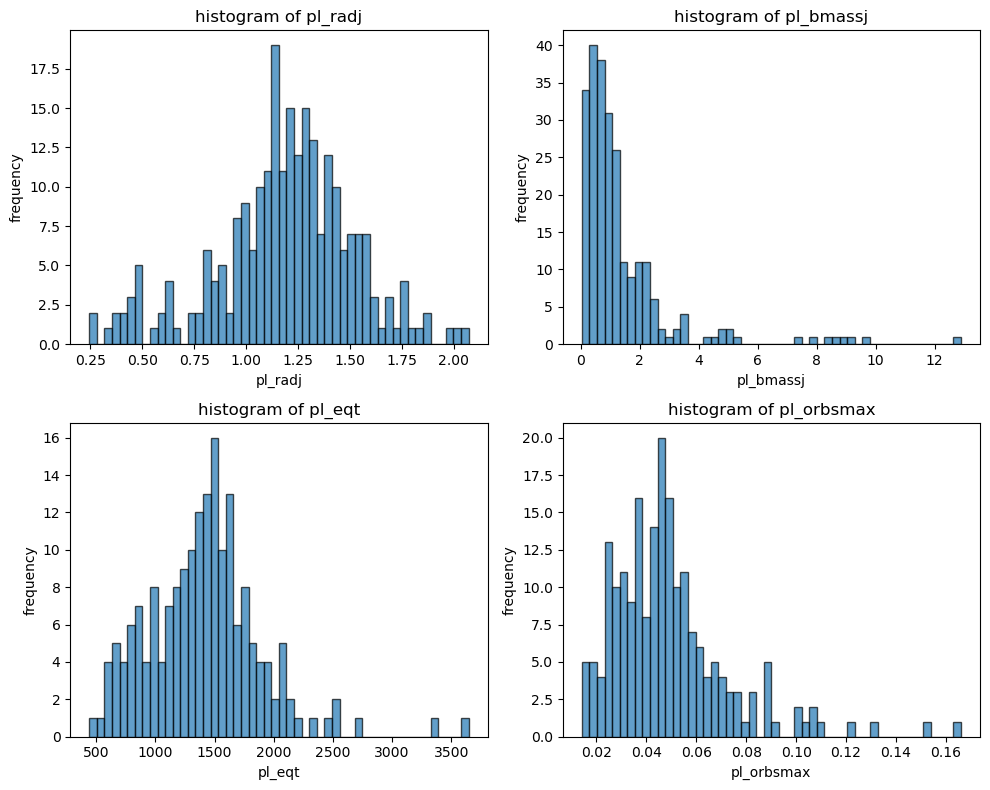

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten() # for ease of use

columns = ['pl_radj', 'pl_bmassj', 'pl_eqt', 'pl_orbsmax'] # 'pl_dens'
bins = 50

for ax, col in zip(axes, columns):
    ax.hist(df_planets[col], bins=bins, alpha=0.7, color='tab:blue', edgecolor='black')
    ax.set_title(f'histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('frequency')

plt.tight_layout()
plt.show()

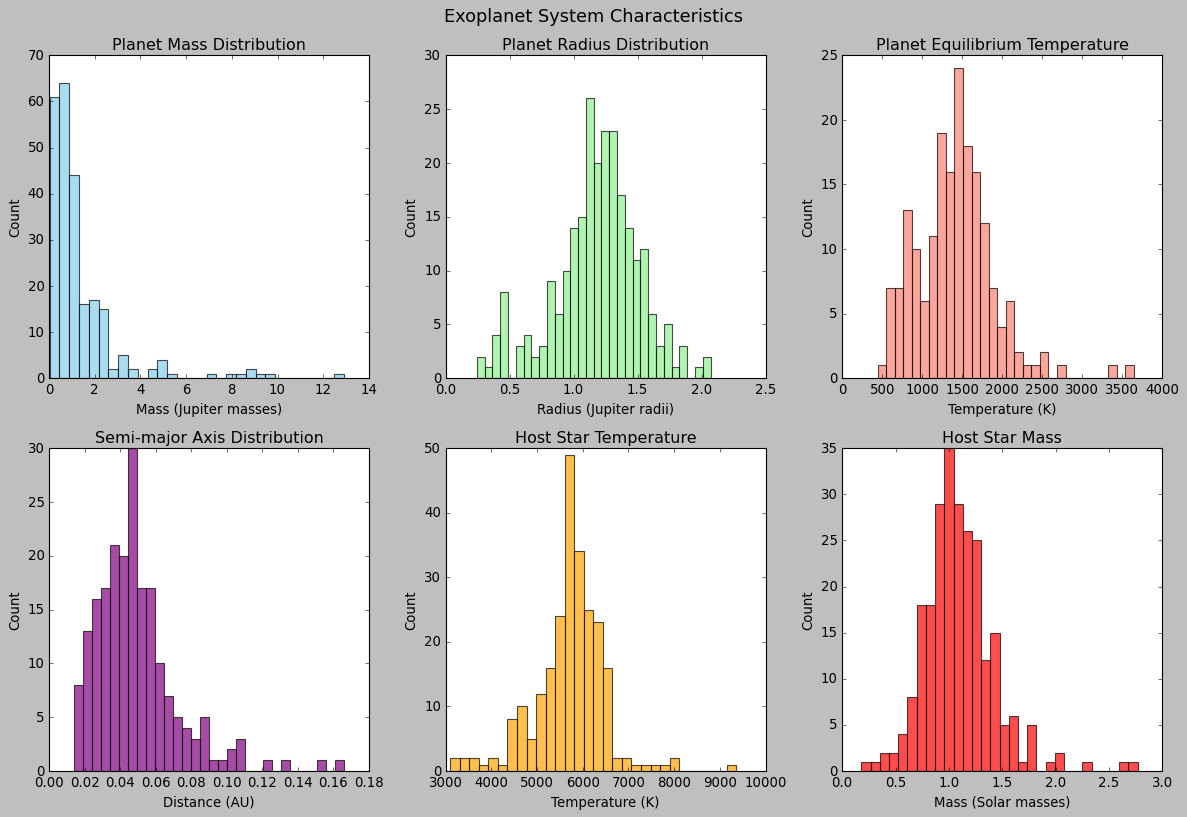

In [108]:
# Set style for better-looking plots
plt.style.use('classic')

# Create figure and subplots - 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot 1: Planet Mass (in Jupiter masses)
axes[0].hist(df_planets['pl_bmassj'].dropna(), bins=30, color='skyblue', alpha=0.7)
axes[0].set_title('Planet Mass Distribution')
axes[0].set_xlabel('Mass (Jupiter masses)')
axes[0].set_ylabel('Count')

# Plot 2: Planet Radius (in Jupiter radii)
axes[1].hist(df_planets['pl_radj'].dropna(), bins=30, color='lightgreen', alpha=0.7)
axes[1].set_title('Planet Radius Distribution')
axes[1].set_xlabel('Radius (Jupiter radii)')
axes[1].set_ylabel('Count')

# Plot 3: Planet Equilibrium Temperature
axes[2].hist(df_planets['pl_eqt'].dropna(), bins=30, color='salmon', alpha=0.7)
axes[2].set_title('Planet Equilibrium Temperature')
axes[2].set_xlabel('Temperature (K)')
axes[2].set_ylabel('Count')

# Plot 4: Semi-major Axis (distance from star)
axes[3].hist(df_planets['pl_orbsmax'].dropna(), bins=30, color='purple', alpha=0.7)
axes[3].set_title('Semi-major Axis Distribution')
axes[3].set_xlabel('Distance (AU)')
axes[3].set_ylabel('Count')

# Plot 5: Stellar Temperature
axes[4].hist(df_planets['st_teff'].dropna(), bins=30, color='orange', alpha=0.7)
axes[4].set_title('Host Star Temperature')
axes[4].set_xlabel('Temperature (K)')
axes[4].set_ylabel('Count')

# Plot 6: Stellar Mass
axes[5].hist(df_planets['st_mass'].dropna(), bins=30, color='red', alpha=0.7)
axes[5].set_title('Host Star Mass')
axes[5].set_xlabel('Mass (Solar masses)')
axes[5].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a main title
fig.suptitle('Exoplanet System Characteristics', y=1.02, fontsize=16)


# Save the figure with high DPI for quality
plt.savefig(f'{output_dir}exoplanet_param_distributions.pdf', 
            dpi=300,  # High resolution
            bbox_inches='tight',  # Includes the full figure with titles
            pad_inches=0.1)  # Slight padding around the plots

# Display the plot (optional)
plt.show()

In [36]:
df_transits.columns

Index(['planet_name', 'priority', 'min_aperture', 'total_observations',
       'recent_observations', 'o_c', 'o_c_uncertainty', 'ra', 'dec', 'mag_r',
       'depth_r', 'duration', 'optimal_target_note', 'drifting_ephemeris_note',
       'meridian_crossing', 'max_counts_r', 'max_counts_v',
       'moon_illumination', 'moon_distance', 'before_ingress_timestamp',
       'before_ingress_alt', 'before_ingress_azi_deg',
       'before_ingress_azi_dir', 'before_ingress_ha',
       'transit_start_timestamp', 'transit_start_alt', 'transit_start_azi_deg',
       'transit_start_azi_dir', 'transit_start_ha', 'mid_transit_timestamp',
       'mid_transit_alt', 'mid_transit_azi_deg', 'mid_transit_azi_dir',
       'mid_transit_ha', 'transit_end_timestamp', 'transit_end_alt',
       'transit_end_azi_deg', 'transit_end_azi_dir', 'transit_end_ha',
       'after_egress_timestamp', 'after_egress_alt', 'after_egress_azi_deg',
       'after_egress_azi_dir', 'after_egress_ha', 'observatory',
       'normalize

### Get priority and duration of each observable transit
- can grab extra columns as needed

In [104]:
agg = {
    'priority': ['max'],
    'duration': ['median', 'count']
}
df_transits_of_interest = df_transits.groupby(['planet_name', 'normalized_planet_name']).agg(agg)
df_transits_of_interest = df_transits_of_interest.reset_index()

# handle column names
clean_col = lambda c1, c2: c1 + ('_' + c2 if len(c2) > 0 else '')
df_transits_of_interest.columns = [clean_col(c[0], c[1])  for c in df_transits_of_interest.columns]
col_map = {'priority_max': 'priority', 'duration_median': 'duration', 'duration_count': 'observable_transits'}
df_transits_of_interest = df_transits_of_interest.rename(col_map, axis=1)

df_transits_of_interest.head()

,planet_name,normalized_planet_name,priority,duration,observable_transits
0,CoRoT-11b,corot11b,LOW,2.49,11
1,CoRoT-2b,corot2b,LOW,2.28,5
2,GJ1214b,gj1214b,LOW,0.87,43
3,GJ3470b,gj3470b,LOW,1.91,5
4,GJ436b,gj436b,MEDIUM,0.99,31


In [111]:
df_planets_with_priority = df_planets.merge(df_transits_of_interest, on='normalized_planet_name')
df_planets_with_priority.head()

,pl_name,hostname,pl_orbper,pl_orbsmax,pl_radj,pl_bmassj,pl_dens,pl_eqt,pl_ratror,pl_orbeccen,pl_eqt.1,pl_insol,pl_orbincl,pl_orblper,pl_orbsmax.1,pl_imppar,pl_orbeccen.1,pl_ratdor,st_teff,st_rad,st_mass,st_met,st_metratio,st_lum,st_age,sy_dist,sy_snum,sy_pnum,sy_mnum,cb_flag,disc_year,disc_facility,rowupdate,releasedate,st_nphot,st_nspec,pl_ndispec,normalized_planet_name,planet_name,priority,duration,observable_transits
0,WASP-80 b,WASP-80,3.067852,0.03440,0.999,0.538,0.717,825.00,0.17137,0.002,825.00,NaN,89.02,94.0,0.03440,0.215,0.002,12.630,4143.0,0.59,0.58,-0.130,[Fe/H],NaN,NaN,4.050,1,1,0,0,2012,SuperWASP,2015-04-16,2015-04-16,0,0,0,wasp80b,WASP-80b,LOW,2.14,3
1,TOI-672 b,TOI-672,3.633575,NaN,0.469,NaN,NaN,676.15,0.08850,NaN,676.15,NaN,88.43,NaN,NaN,0.424,NaN,15.503,3765.0,0.54,0.54,-0.710,[Fe/H],NaN,NaN,NaN,1,1,0,0,2023,Transiting Exoplanet Survey Satellite (TESS),2023-05-26,2023-05-26,0,0,0,toi672b,TOI-672b,LOW,1.80,13
2,KELT-17 b,KELT-17,3.080172,0.04881,1.525,1.310,0.460,2087.00,0.09526,NaN,2087.00,NaN,84.87,NaN,0.04881,0.570,NaN,6.380,7454.0,1.65,1.64,-0.018,[Fe/H],0.876,0.65,0.518,1,1,0,0,2016,KELT,2019-12-02,2016-09-08,0,0,0,kelt17b,KELT-17b,LOW,3.47,2
3,WASP-166 b,WASP-166,5.443540,0.06410,0.630,0.101,0.540,1270.00,NaN,0.000,1270.00,440.0,88.00,NaN,0.06410,0.390,0.000,11.300,6050.0,1.22,1.19,0.190,[Fe/H],NaN,2.10,0.920,1,1,0,0,2019,WASP-South,2019-07-19,2019-07-25,0,0,0,wasp166b,WASP-166b,HIGH,3.60,3
4,WASP-107 b,WASP-107,5.721474,NaN,NaN,0.096,0.134,NaN,NaN,0.060,NaN,NaN,NaN,40.0,NaN,NaN,0.060,NaN,4425.0,0.67,0.68,0.020,[Fe/H],-0.879,3.40,NaN,1,2,0,0,2017,SuperWASP-South,2020-12-10,2020-12-17,0,0,0,wasp107b,WASP-107b,MEDIUM,2.77,14


In [112]:
df_planets_with_priority['priority'].value_counts()

priority
LOW         122
MEDIUM       61
HIGH         47
ALERT        16
TTVs          5
CAMPAIGN      1
Name: count, dtype: int64

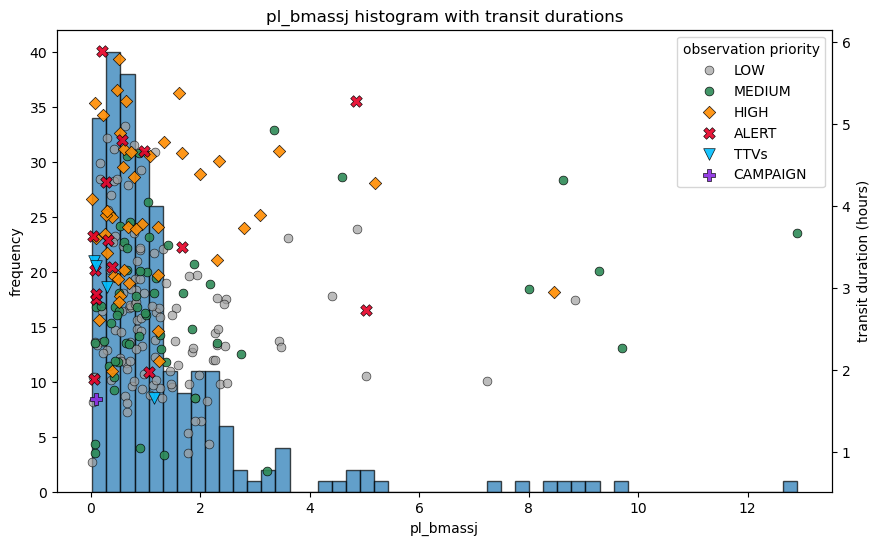

In [115]:
plt.style.use('default')

priority_colors = {
    'LOW': 'tab:gray', 
    'MEDIUM': 'tab:green', 
    'HIGH': 'tab:orange',
    'ALERT': 'tab:red',
    'TTVs': 'tab:cyan',
    'CAMPAIGN': 'tab:purple',
}
priority_colors = {
    'LOW': '#A0A0A0',        # Soft Gray (neutral)
    'MEDIUM': '#2E8B57',     # Sea Green (calm but noticeable)
    'HIGH': '#FF8C00',       # Dark Orange (stands out)
    'ALERT': '#E60026',      # Bright Red (urgent)
    'TTVs': '#00BFFF',       # Deep Sky Blue (cool and distinct)
    'CAMPAIGN': '#8A2BE2',   # Blue Violet (bold and eye-catching)
}
# priority_colors = {
#     'LOW': '#B0B0B0',       # Light Gray
#     'MEDIUM': '#28A745',    # Vibrant Green
#     'HIGH': '#FF4500',      # Bright Orange-Red
#     'ALERT': '#D00000',     # Deeper Red
#     'TTVs': '#00CFFF',      # Electric Blue
#     'CAMPAIGN': '#9932CC',  # Dark Orchid Purple
# }

# marker ref: https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html#filled-markers
priority_markers = {
    'LOW': 'o',
    'MEDIUM': 'o',
    'HIGH': 'D',
    'ALERT': 'X',
    'TTVs': 'v',
    'CAMPAIGN': 'P'
}

bins = 50

col = 'pl_bmassj'

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(df_planets_with_priority[col], bins=bins, alpha=0.7, color='tab:blue', edgecolor='black')
ax1.set_xlabel(col)
ax1.set_ylabel('frequency')

ax2 = ax1.twinx()
for priority, color in priority_colors.items():
    subset = df_planets_with_priority[df_planets_with_priority['priority'] == priority]
    alpha = 0.7 if priority == 'LOW' else 0.9
    marker = priority_markers[priority]
    marker_size = 40 if priority in ('LOW', 'MEDIUM', 'HIGH') else 70
    ax2.scatter(subset['pl_bmassj'], subset['duration'], label=priority, color=color, 
                alpha=alpha, marker=marker, edgecolors='black', linewidth=0.5, s=marker_size)

ax2.set_ylabel('transit duration (hours)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(title="observation priority", loc='upper right')

plt.title(f'{col} histogram with transit durations')

plt.savefig(f'{output_dir}exoplanets_{col}_with_transit_durations.pdf', 
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1)

plt.show()

### Put it all together

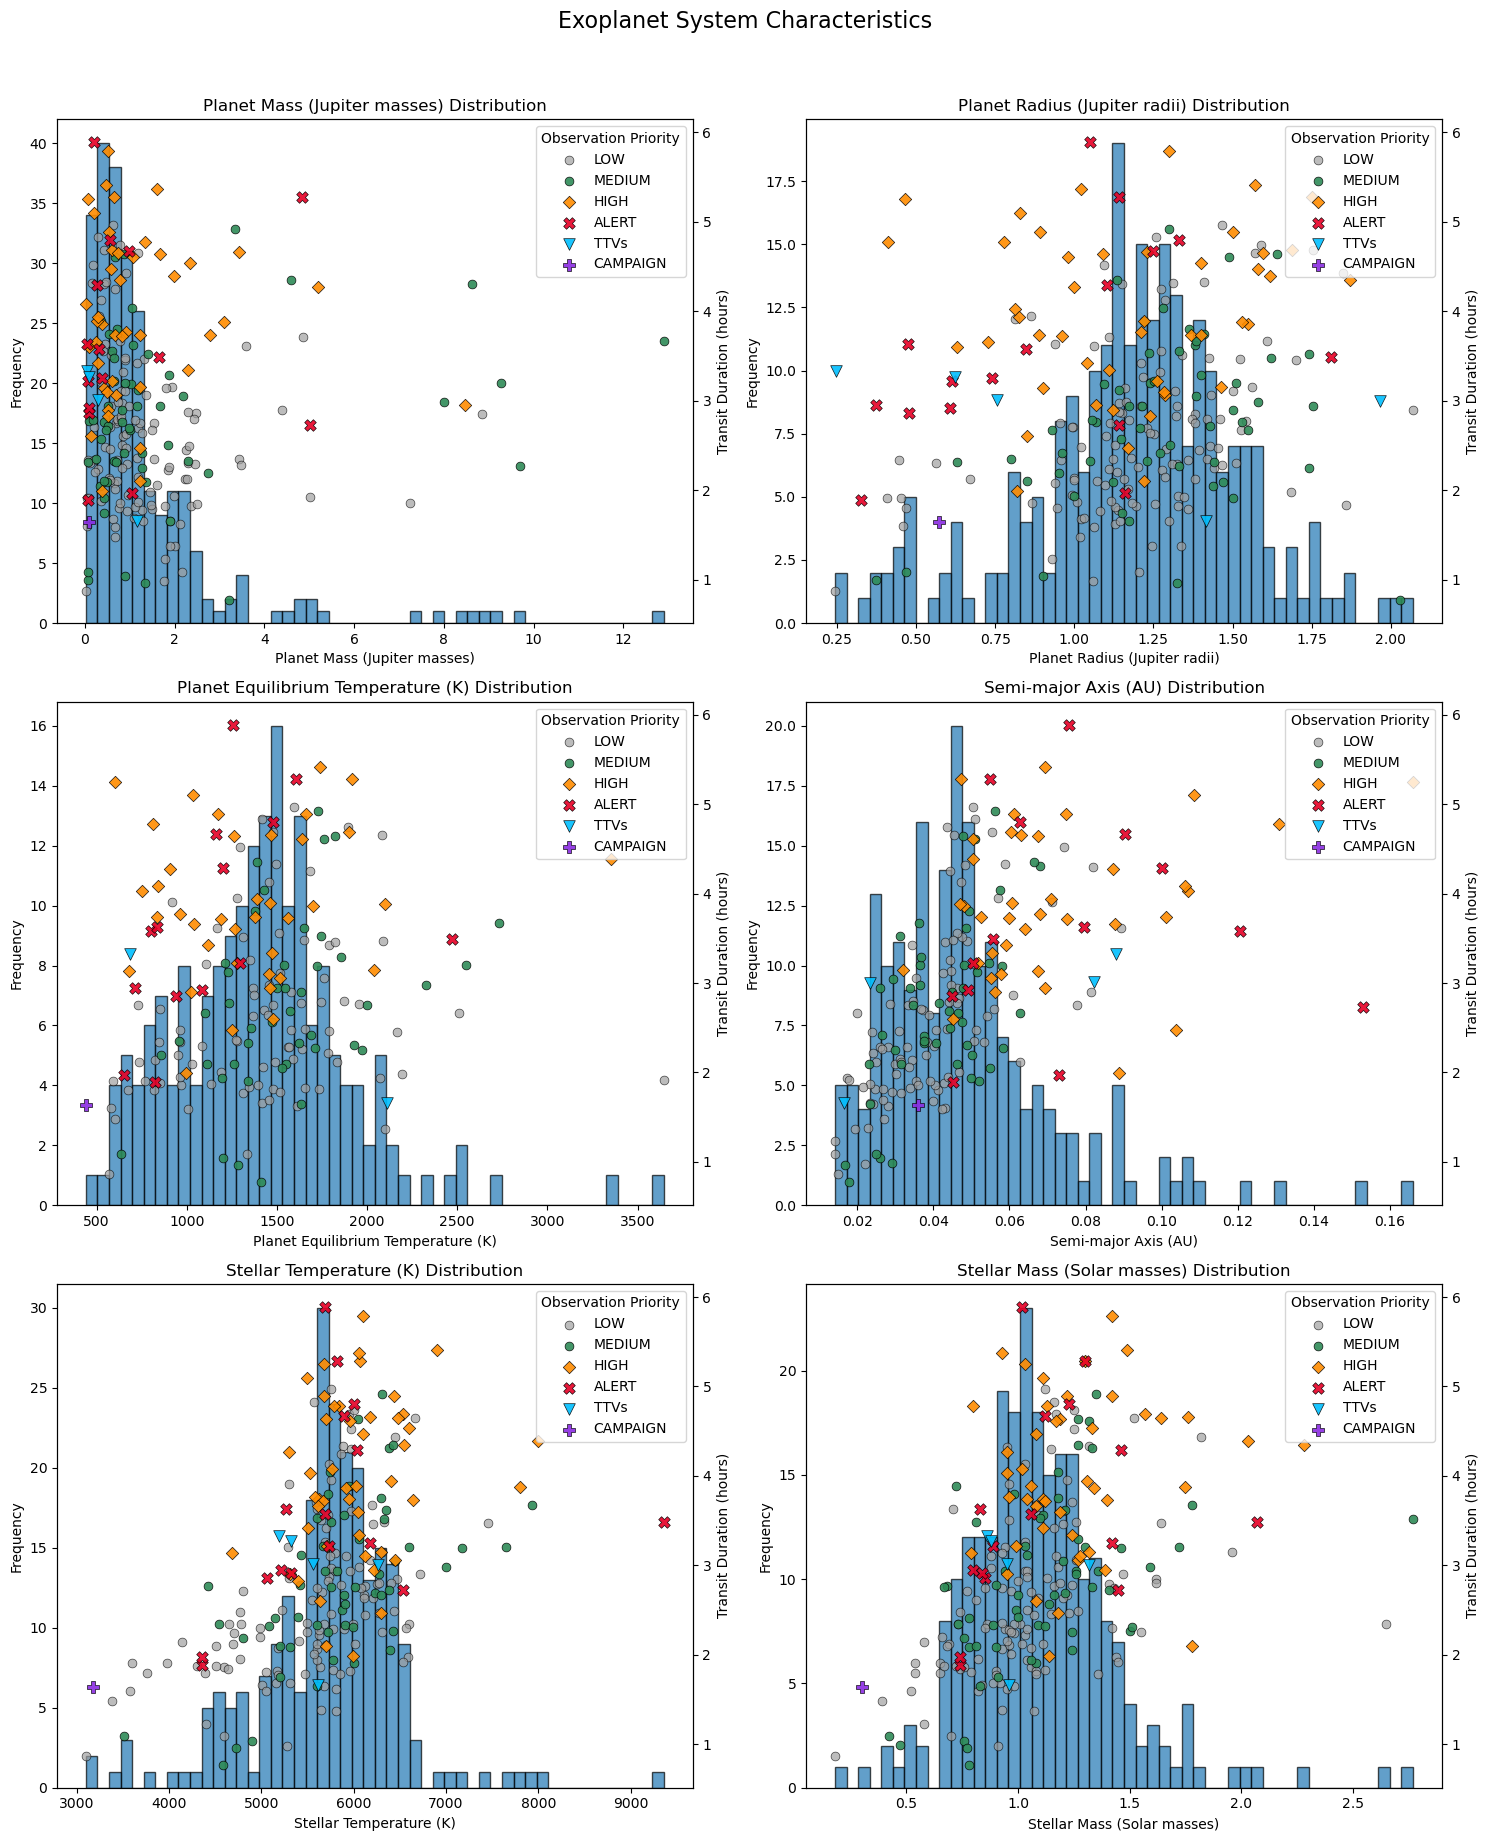

In [117]:
def plot_parameter_histogram(ax1, df, column, priority_colors, priority_markers, friendly_name_map):
    bins = 50
    
    ax1.hist(df[column], bins=bins, alpha=0.7, color='tab:blue', edgecolor='black')
    ax1.set_xlabel(friendly_name_map[column])
    ax1.set_ylabel('Frequency')
    
    ax2 = ax1.twinx()
    for priority, color in priority_colors.items():
        subset = df[df['priority'] == priority]
        alpha = 0.7 if priority == 'LOW' else 0.9
        marker = priority_markers[priority]
        marker_size = 40 if priority in ('LOW', 'MEDIUM', 'HIGH') else 70
        ax2.scatter(subset[column], subset['duration'], 
                   label=priority, color=color, 
                   alpha=alpha, marker=marker, 
                   edgecolors='black', linewidth=0.5, s=marker_size)
    
    ax2.set_ylabel('Transit Duration (hours)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(title="Observation Priority", loc='upper right')
    ax1.set_title(f'{friendly_name_map[column]} Distribution')

# Define color and marker styles
priority_colors = {
    'LOW': '#A0A0A0',
    'MEDIUM': '#2E8B57',
    'HIGH': '#FF8C00',
    'ALERT': '#E60026',
    'TTVs': '#00BFFF',
    'CAMPAIGN': '#8A2BE2',
}

priority_markers = {
    'LOW': 'o',
    'MEDIUM': 'o',
    'HIGH': 'D',
    'ALERT': 'X',
    'TTVs': 'v',
    'CAMPAIGN': 'P'
}

plt.style.use('default')

# Create figure with 3x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

# Define columns to plot
columns = ['pl_bmassj', 'pl_radj', 'pl_eqt', 'pl_orbsmax', 'st_teff', 'st_mass']
friendly_name_map = {
    'pl_bmassj': 'Planet Mass (Jupiter masses)',
    'pl_radj': 'Planet Radius (Jupiter radii)',
    'pl_eqt': 'Planet Equilibrium Temperature (K)',
    'pl_orbsmax': 'Semi-major Axis (AU)',
    'st_teff': 'Stellar Temperature (K)',
    'st_mass': 'Stellar Mass (Solar masses)'
}

# Create plots
for ax, col in zip(axes, columns):
    plot_parameter_histogram(ax, df_planets_with_priority, col, priority_colors, priority_markers, friendly_name_map)

fig.suptitle('Exoplanet System Characteristics', y=1.02, fontsize=16)
plt.tight_layout()

plt.savefig(f'{output_dir}exoplanet_param_distributions_with_transits.pdf', 
            dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()